# Installs + Imports

In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import re
import warnings

from tensorflow.keras.utils import pad_sequences
from wordcloud import WordCloud
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multioutput import ClassifierChain
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, zero_one_loss, coverage_error, \
                            label_ranking_loss, label_ranking_average_precision_score
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

# Global Variables

In [ ]:
LABELS = ['programming', 'style', 'reference', 'java', 'web', 'internet', 'culture', 'design', 'education', 'language',
          'books', 'writing', 'computer', 'english', 'politics', 'history', 'philosophy', 'science', 'religion',
          'grammar']

# Helpers

In [ ]:
def read_data(file, lab_file):
    X_data = pd.read_csv(file, header=None)
    y_data = pd.read_csv(lab_file, header=None)
    X_data = X_data[0].map(lambda x: re.sub('<\d+>', '', x).strip().split())
    X_data = X_data.map(lambda x: [int(tok.strip()) for tok in x])
    y_data = y_data[0].map(lambda x: np.array([int(lab) for lab in x.split()]))

    return X_data.tolist(), np.array(y_data.tolist())


def load_dataset(maxlen, path='./Data', binary=False):

  with zipfile.ZipFile(path + ".zip", 'r') as zip_ref:
    zip_ref.extractall()

  train_data = path + '/train-data.dat'
  train_labels = path + '/train-label.dat'
  test_data = path + '/test-data.dat'
  test_labels = path + '/test-label.dat'

  print('Loading data...')
  X_train, y_train = read_data(train_data, train_labels)
  X_test, y_test = read_data(test_data, test_labels)
  print(len(X_train), 'train sequences')
  print(len(X_test), 'test sequences')

  # Padding data.
  X_train = pad_sequences(X_train, maxlen=maxlen)
  X_test = pad_sequences(X_test, maxlen=maxlen)
  print('X_train shape:', X_train.shape)
  print('X_test shape:', X_test.shape)

  if binary:
      # Get the most frequent class only.
      print('\nGetting the most frequent class...')
      most_frequent_counts = np.sum(np.transpose(y_train), axis=1)
      most_frequent_index = most_frequent_counts.argmax()
      y_train = y_train[:, most_frequent_index]
      y_test = y_test[:, most_frequent_index]
      print('The most frequent class was the word \'{}\', with {} appearances.'
            .format(LABELS[most_frequent_index], most_frequent_counts.max()))

  return X_train, y_train, X_test, y_test

# MAIN

## Load, Scale and Visualize Dataset

In [ ]:
X_train, y_train, X_test, y_test = load_dataset(maxlen=200)

Loading data...
8251 train sequences
3983 test sequences
X_train shape: (8251, 200)
X_test shape: (3983, 200)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

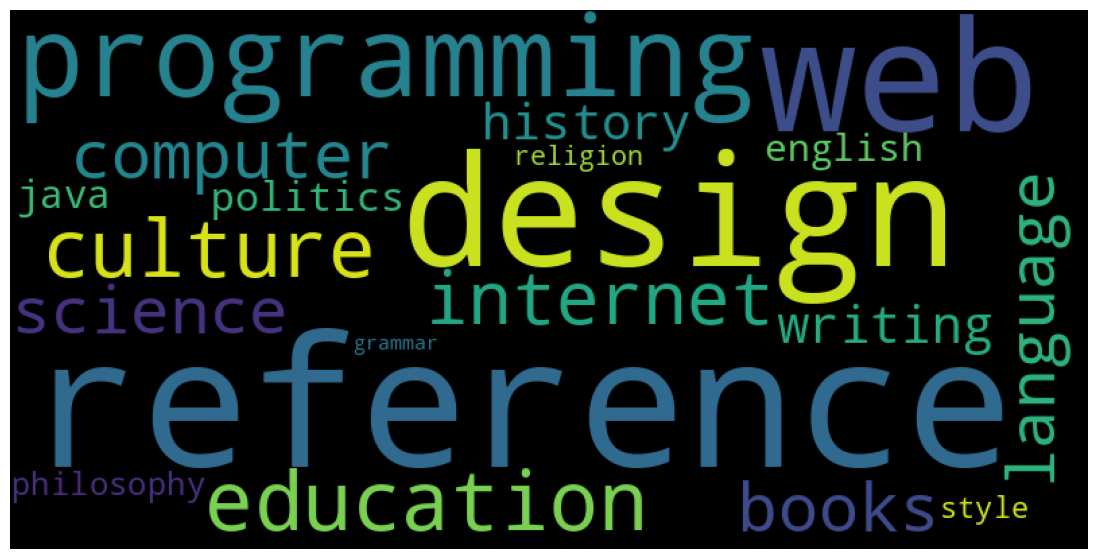

In [ ]:
test = np.transpose(y_train)
cumsum = np.sum(test, axis=1)

labelsdict = {LABELS[i]: cumsum[i] for i in range(len(LABELS))}
cloud = WordCloud(width=800, height=400).generate_from_frequencies(labelsdict)
plt.figure(figsize=(20, 7))
plt.imshow(cloud)
plt.axis('off')
plt.show()

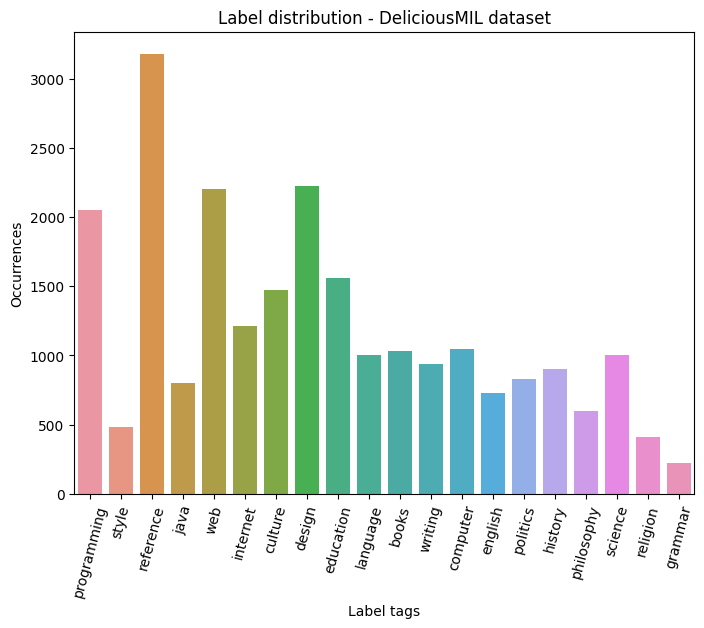

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=LABELS, y=cumsum)
plt.xticks(rotation=75)
plt.xlabel('Label tags')
plt.ylabel('Occurrences')
plt.title("Label distribution - DeliciousMIL dataset")
plt.show()

## 1. Binary Relevance

In [ ]:
names = ['LogisticRegression', 'MultinomialNB', 'RandomForest']
classifiers = [
    BinaryRelevance(LogisticRegression(random_state=0, solver='lbfgs')),
    BinaryRelevance(MultinomialNB()),
    BinaryRelevance(RandomForestClassifier(n_estimators=30))
]

for name, clf in zip(names, classifiers):
  print(f"\n\n{name}\n")
  clf.fit(X_train, y_train)
  y_preds = clf.predict(X_test)
  y_pred_probs = clf.predict_proba(X_test)

  print(classification_report(y_test, y_preds))
  print(f"One-Error = {zero_one_loss(y_test, y_preds):.2f}")
  print(f"Coverage Error = {coverage_error(y_test, y_pred_probs.toarray())}")
  print(f"Ranking Loss = {label_ranking_loss(y_test, y_pred_probs.toarray())}")
  print(f"Average Precision = {label_ranking_average_precision_score(y_test, y_pred_probs.toarray())}")



LogisticRegression

              precision    recall  f1-score   support

           0       0.40      0.02      0.04       977
           1       0.00      0.00      0.00       228
           2       0.43      0.09      0.15      1558
           3       0.00      0.00      0.00       372
           4       0.23      0.01      0.01      1050
           5       0.00      0.00      0.00       537
           6       0.23      0.00      0.01       702
           7       0.25      0.01      0.01      1079
           8       0.00      0.00      0.00       803
           9       0.00      0.00      0.00       483
          10       0.00      0.00      0.00       507
          11       0.00      0.00      0.00       478
          12       0.00      0.00      0.00       509
          13       0.00      0.00      0.00       355
          14       0.00      0.00      0.00       392
          15       0.00      0.00      0.00       441
          16       0.00      0.00      0.00       269
     

Από τα παραπάνω παρατηρώ ότι:
1. τα αποτελέσματα **δεν** είναι ιδιαίτερα καλά.
2. Σε κάποιες κλάσεις έχουμε καλύτερα αποτελέσματα και σε κάποιες άλλες χειρότερα.
3. Όσον αφορά τα One-Error, Coverage Error, Ranking Loss και Average Precision το μοντέλο Multinomial Naive Bias πευχαίνει τα καλύτερα αποτελέσματα.
4. Όσον αφορά το precision, το Random Forest είναι αυτό που δίνει τα χειρότερα αποτελέσματα.
5. Γενικότερα, στις υπόλοιπες μετρικές (Recall, F1) τα αποτελέσματα δεν είναι καλά.

## 2. Classifier Chains

In [ ]:
names = ['LogisticRegression', 'MultinomialNB', 'RandomForest']
classifiers = [
    ClassifierChain(LogisticRegression(random_state=0, solver='lbfgs')),
    ClassifierChain(MultinomialNB()),
    ClassifierChain(RandomForestClassifier(n_estimators=30))
]

for name, clf in zip(names, classifiers):
  print(f"\n\n{name}\n")
  clf.fit(X_train, y_train)
  y_preds = clf.predict(X_test)
  y_pred_probs = clf.predict_proba(X_test)

  print(classification_report(y_test, y_preds))
  print(f"One-Error = {zero_one_loss(y_test, y_preds):.2f}")
  print(f"Coverage Error = {coverage_error(y_test, y_pred_probs)}")
  print(f"Ranking Loss = {label_ranking_loss(y_test, y_pred_probs)}")
  print(f"Average Precision = {label_ranking_average_precision_score(y_test, y_pred_probs)}")



LogisticRegression

              precision    recall  f1-score   support

           0       0.40      0.02      0.04       977
           1       0.00      0.00      0.00       228
           2       0.43      0.06      0.10      1558
           3       0.00      0.00      0.00       372
           4       0.38      0.01      0.02      1050
           5       0.00      0.00      0.00       537
           6       0.25      0.02      0.04       702
           7       0.33      0.01      0.01      1079
           8       0.16      0.01      0.01       803
           9       0.25      0.00      0.00       483
          10       0.00      0.00      0.00       507
          11       0.00      0.00      0.00       478
          12       0.00      0.00      0.00       509
          13       0.00      0.00      0.00       355
          14       0.13      0.03      0.05       392
          15       0.27      0.01      0.02       441
          16       0.20      0.01      0.03       269
     

Από τα παραπάνω παρατηρώ ότι:
1. τα αποτελέσματα **δεν** είναι ιδιαίτερα καλά.
2. Σε κάποιες κλάσεις έχουμε καλύτερα αποτελέσματα και σε κάποιες άλλες χειρότερα.
3. Όσον αφορά τα One-Error, Coverage Error, Ranking Loss και Average Precision το μοντέλο Multinomial Naive Bias πευχαίνει τα καλύτερα αποτελέσματα.
4. Όσον αφορά το precision, το Random Forest είναι αυτό που δίνει τα χειρότερα αποτελέσματα.
5. Γενικότερα, στις υπόλοιπες μετρικές (Recall, F1) τα αποτελέσματα δεν είναι καλά.